In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error as MSE

import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../SAC/')
import kinematics_preprocessing_specs

import config

parser = config.config_parser()
args, unknown = parser.parse_known_args()

In [2]:
#Select the target/marker for which to visualize the kinematics
marker= 0

In [3]:
#Load the test data of usim
with open('../test_data/test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)
    
print(test_data.keys())

dict_keys(['emg', 'rnn_activity', 'rnn_input', 'rnn_input_fp', 'kinematics_mbodies', 'kinematics_mtargets'])


In [4]:
#Get the timepoints of each condition per cycle
with open('../kinematics_data/kinematics.pkl', 'rb') as file:
    kin_train_test = pickle.load(file)
    
kin_train = kin_train_test['train']
kin_test = kin_train_test['test']

#First update the keys of self.kin_test
for cond in range(len(kin_test)):
    kin_test[len(kin_train) + cond] = kin_test.pop(cond)
    
kin = kin_train.copy()
kin.update(kin_test)

In [7]:
conds = [kin[cond].shape[-1] for cond in range(len(kin))]
total_conds = len(conds)

#Select the cycle for each condition (training conditions followed by testing): 0 for 1st cycle and so on
#The number of elements should be equal to num_train_conditions + num_test_conditions
cycles = [3, 3, 3, 3, 3, 3]

#Number of fixedsteps in the start of each condition
n_fixedsteps= args.n_fixedsteps

In [10]:
#Load the usim kinematics
kin_agent = []

for idx, cond_kin in test_data['kinematics_mbodies'].items():
    kin_agent_cond = cond_kin
    kin_agent_cond = kin_agent_cond[marker, n_fixedsteps + cycles[idx] * conds[idx] : n_fixedsteps + (cycles[idx]+1) * conds[idx], :]
    print(kin_agent_cond.shape)
    kin_agent.append(kin_agent_cond[:, :])

(702, 3)
(803, 3)
(932, 3)
(1319, 3)
(619, 3)
(1106, 3)


In [13]:
#Load the usim simulated/target kinematics
kin_sim = []

for idx, cond_kin in test_data['kinematics_mtargets'].items():
    kin_sim_cond = cond_kin
    kin_sim_cond = kin_sim_cond[marker, n_fixedsteps + cycles[idx] * conds[idx] : n_fixedsteps + (cycles[idx]+1) * conds[idx], :]
    print(kin_sim_cond.shape)
    kin_sim.append(kin_sim_cond[:, :])

(702, 3)
(803, 3)
(932, 3)
(1319, 3)
(619, 3)
(1106, 3)


MSE for COND 0:  8.255216372422502e-06


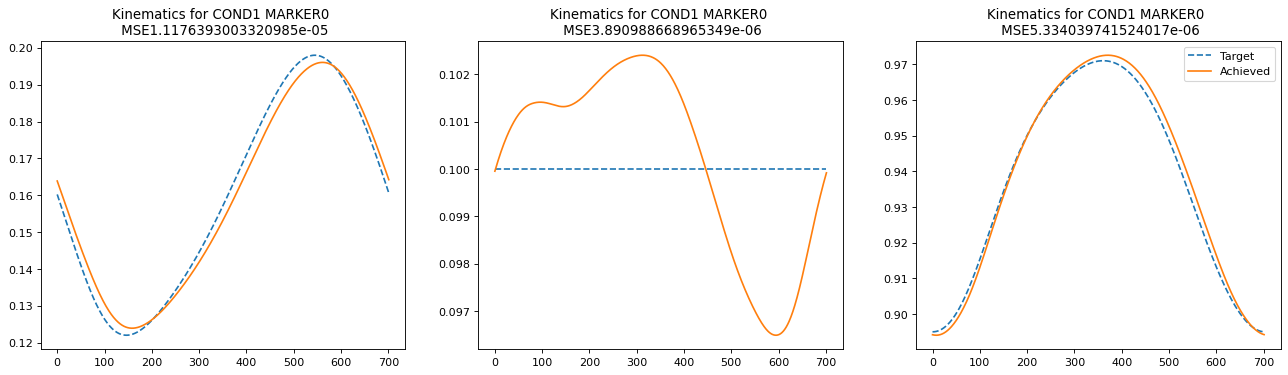

MSE for COND 1:  5.8616154378684696e-06


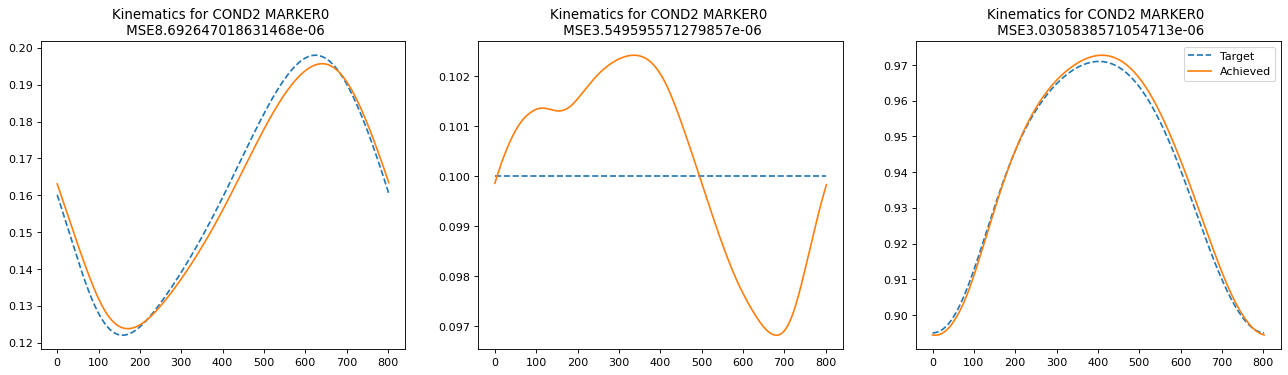

MSE for COND 2:  4.569150543283164e-06


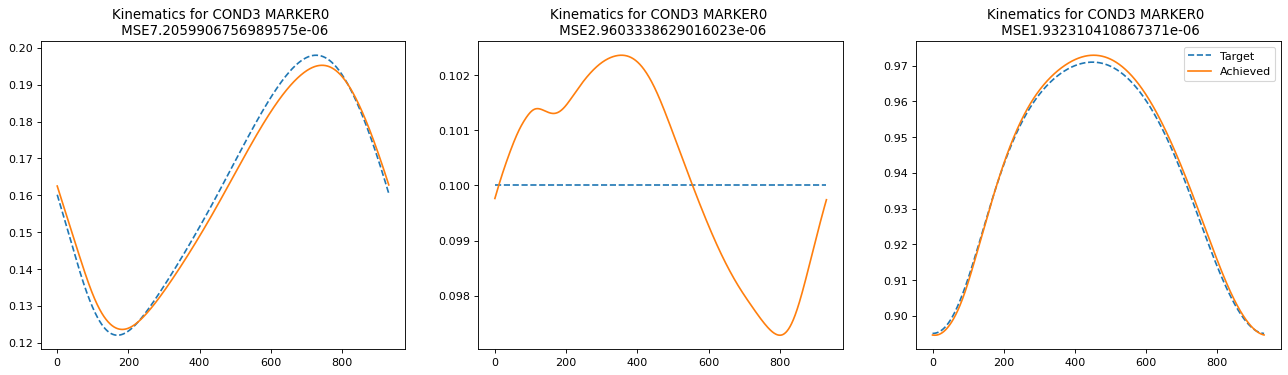

MSE for COND 3:  4.377522215212467e-06


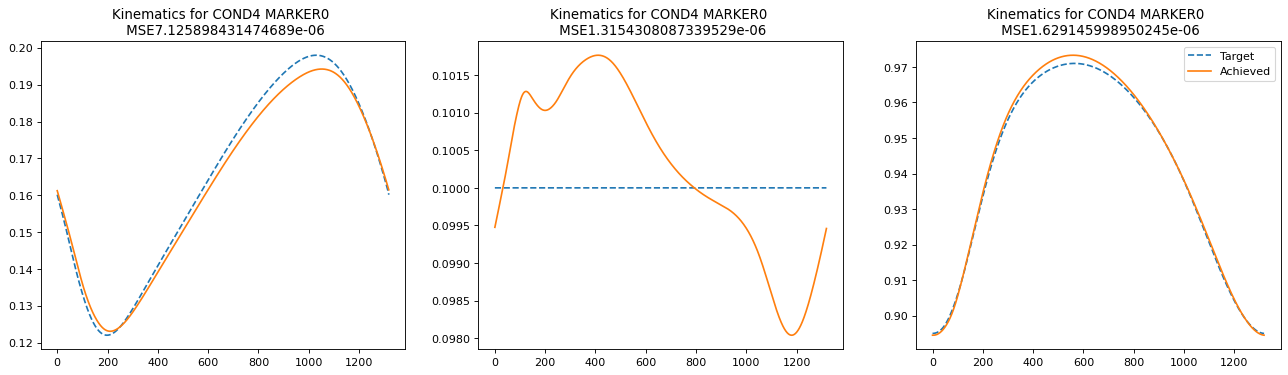

MSE for COND 4:  1.2092028854259684e-05


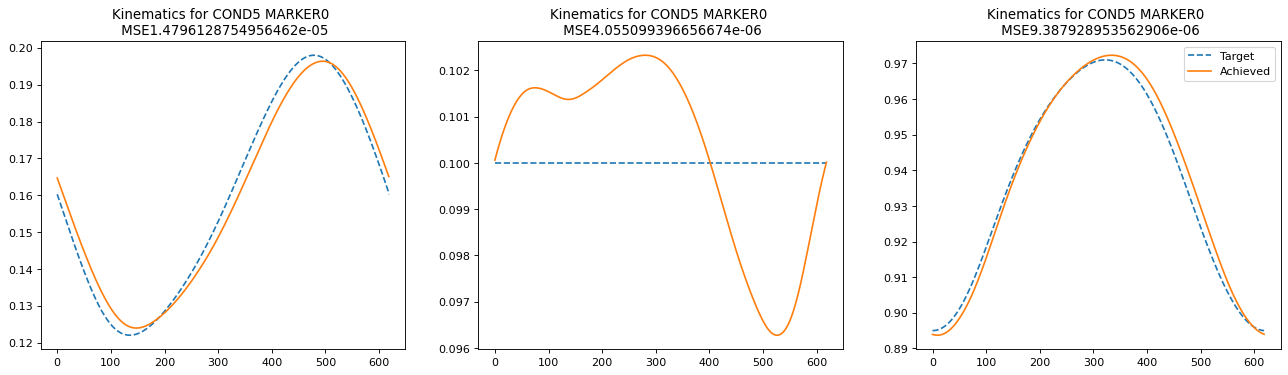

MSE for COND 5:  4.128065094810159e-06


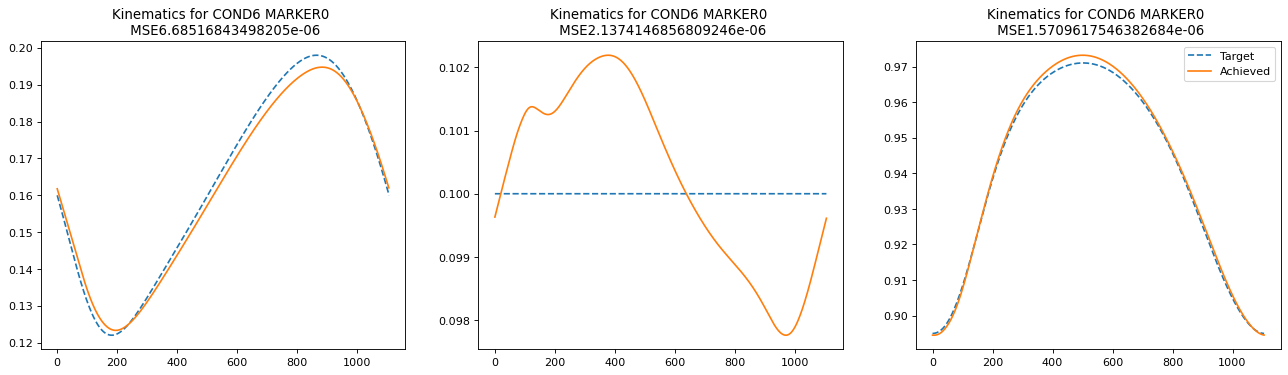

In [15]:
for cond in range(len(kin_agent)):
    figure(figsize=(20, 5), dpi=80)
    
    MSE_cond = 0
    for coord in range(kin_agent[cond].shape[-1]):
        
        plt.subplot(1, kin_agent[cond].shape[-1], coord+1)
        plt.plot(kin_sim[cond][:, coord], '--', label= 'Target')
        plt.plot(kin_agent[cond][:, coord], label= 'Achieved')
        
        MSE_coord = MSE(kin_sim[cond][:, coord], kin_agent[cond][:, coord])
        
        plt.title(f'Kinematics for COND{cond+1} MARKER{marker} \n MSE{MSE_coord}')
        
        #omit the z coord for MSE calculations
        if coord != 1:
            MSE_cond += MSE_coord
    
    print(f'MSE for COND {cond}: ',  MSE_cond/2)
    plt.legend()
    plt.show()

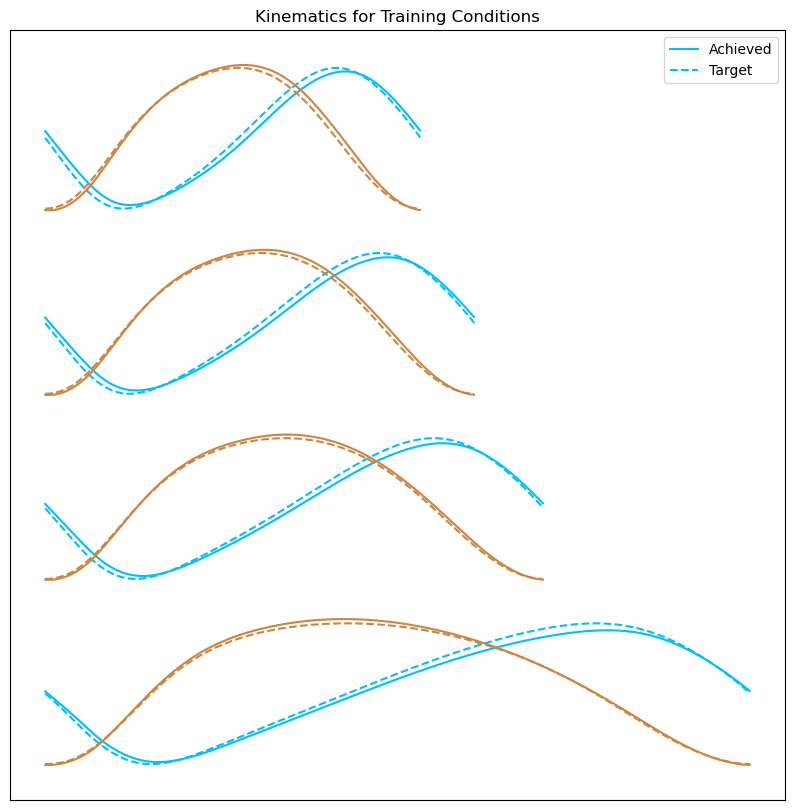

In [16]:
#Now plot the kinematics for all training conditions together

plt.figure(figsize= (10, 10));

for cond in range(len(kin_train)):
    for coord in range((kin_agent[cond].shape[-1])):
        
        if coord != 1:
            
            kin_agent_coord = kin_agent[cond][:, coord]
            kin_sim_coord = kin_sim[cond][:, coord]
            
            #Normalize for pretty display
            norm_factor = np.min(kin_sim_coord) + np.ptp(kin_sim_coord)/2
            
            kin_agent_coord = (kin_agent_coord - norm_factor)
            kin_sim_coord = (kin_sim_coord - norm_factor)
            
            if coord == 0:
                col=(0/255, 191/255, 255/255)
            else:
                col=(205/255, 133/255, 63/255)    
            
            plt.plot(kin_agent_coord - cond*0.1, '-', linewidth= 1.5, c=col)
            plt.plot(kin_sim_coord - cond*0.1, '--', linewidth= 1.5, c=col)

plt.xticks([])
plt.yticks([])

plt.title('Kinematics for Training Conditions')
plt.legend(['Achieved', 'Target'])
plt.show()

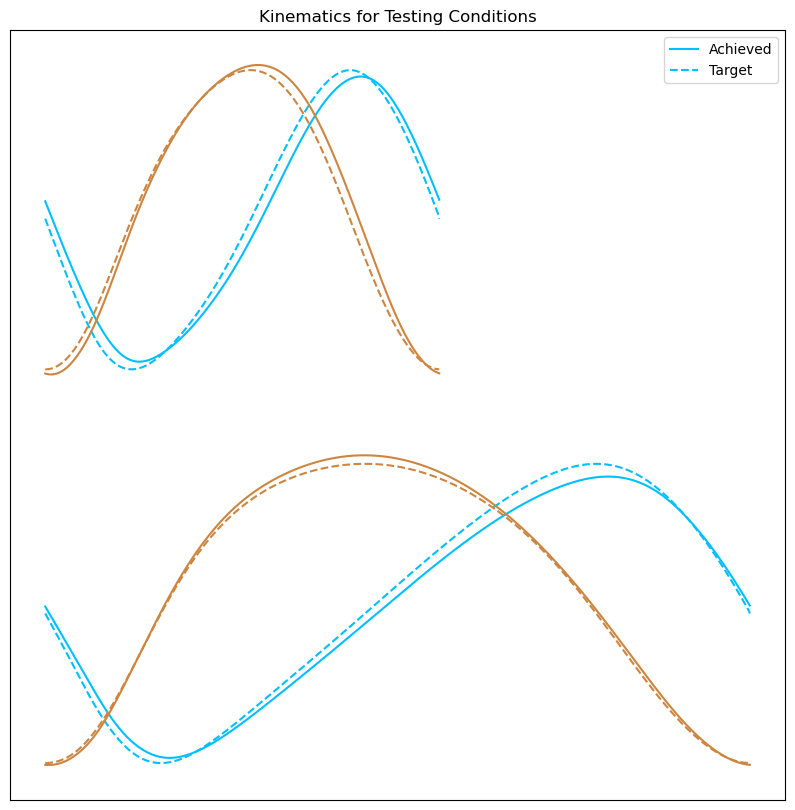

In [19]:
#Now plot the kinematics for all testing conditions together

plt.figure(figsize= (10, 10));

for cond in range(len(kin_test)):
    for coord in range((kin_agent[cond+len(kin_train)].shape[-1])):
        
        if coord != 1:
            
            kin_agent_coord = kin_agent[cond+len(kin_train)][:, coord]
            kin_sim_coord = kin_sim[cond+len(kin_train)][:, coord]
            
            #Normalize for pretty display
            norm_factor = np.min(kin_sim_coord) + np.ptp(kin_sim_coord)/2
            
            kin_agent_coord = (kin_agent_coord - norm_factor)
            kin_sim_coord = (kin_sim_coord - norm_factor)
            
            if coord == 0:
                col=(0/255, 191/255, 255/255)
            else:
                col=(205/255, 133/255, 63/255)    
            
            plt.plot(kin_agent_coord - cond*0.1, '-', linewidth= 1.5, c=col)
            plt.plot(kin_sim_coord - cond*0.1, '--', linewidth= 1.5, c=col)

plt.xticks([])
plt.yticks([])

plt.title('Kinematics for Testing Conditions')
plt.legend(['Achieved', 'Target'])
plt.show()